In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
from utils import (SingleNeuron_Data, Network_Data, CellType_Dataset_Fast, model_network,
                   linear_scale_forward, log_scale_forward, UniformPrior, section_drive_param_function)
import multiprocessing
from typing import Dict, Tuple, Optional, List
import dill
from utils import ConcatTensorDataset
from TCN.tcn import model_TCN

device = torch.device("cuda:0")
# device = 'cpu'
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

data_path = f'/users/ntolley/scratch/bayesian_surrogates/datasets_subthreshold'


--No graphics will be displayed.


In [2]:
# Define simulation function
#---------------------------
def update_net(net, thetai, sample_idx, prior_dict, transform_dict=None, suffix='subthreshold', rate=20.0):

    theta_dict = {param_name: param_dict['rescale_function'](thetai[param_idx].numpy(), param_dict['bounds']) for 
                    param_idx, (param_name, param_dict) in enumerate(prior_dict.items())}


    theta_extra = {'cell_type_lookup': cell_type_lookup, 'valid_conn_list': list(),
                   'valid_drive_dict': dict()}
    # Connections
    for conn_idx in range(len(net.connectivity)):
        src_type = cell_type_lookup[net.connectivity[conn_idx]['src_type']]
        target_type = cell_type_lookup[net.connectivity[conn_idx]['target_type']]
        receptor = net.connectivity[conn_idx]['receptor']
        loc = net.connectivity[conn_idx]['loc']
        
        conn_name = f'{src_type}_{target_type}_{receptor}_{loc}'
        theta_extra['valid_conn_list'].append(conn_name)
        theta_extra[f'{conn_name}_conn_idx'] = conn_idx

    # Drives
    for cell_type in net.cell_types.keys():
        for sec_name in net.cell_types[cell_type].sections.keys():
            for syn_name in net.cell_types[cell_type].sections[sec_name].syns:
                drive_name = f'{cell_type}_{sec_name}_{syn_name}'
                theta_extra['valid_drive_dict'][drive_name] = {
                    'cell_type': cell_type, 'location': sec_name, 'receptor': syn_name}

    theta_extra['sample_idx'] =  sample_idx
    theta_dict['theta_extra'] = theta_extra

    section_drive_param_function(net, theta_dict, rate=rate)
    # dpl = simulate_dipole(net, dt=0.5, tstop=500, record_vsec='all', record_isec='all', record_dcell=True)

In [3]:
hnn_core_root = op.dirname(hnn_core.__file__)
params_fname = op.join(hnn_core_root, 'param', 'default.json')
params = read_params(params_fname)
params.update({'N_pyr_x': 10, 'N_pyr_y': 10})
net = calcium_model(params)

In [4]:
prior_dict = dict()
# prior_dict['lamtha'] = {'bounds': (0, 10), 'rescale_function': linear_scale_forward}

cell_type_lookup = {
    'L2_pyramidal': 'L2e', 'L2_basket': 'L2i',
    'L5_pyramidal': 'L5e', 'L5_basket': 'L5i'}

# Connections
for conn_idx in range(len(net.connectivity)):
    src_type = cell_type_lookup[net.connectivity[conn_idx]['src_type']]
    target_type = cell_type_lookup[net.connectivity[conn_idx]['target_type']]
    receptor = net.connectivity[conn_idx]['receptor']
    loc = net.connectivity[conn_idx]['loc']
    
    conn_name = f'{src_type}_{target_type}_{receptor}_{loc}'
    
    prior_dict[f'{conn_name}_gbar'] = {'bounds': (-4, 0), 'rescale_function': log_scale_forward}
    prior_dict[f'{conn_name}_prob'] = {'bounds': (0.9, 1), 'rescale_function': linear_scale_forward}

# Drives
for cell_type in net.cell_types.keys():
    for sec_name in net.cell_types[cell_type].sections.keys():
        for syn_name in net.cell_types[cell_type].sections[sec_name].syns:
            drive_name = f'{cell_type}_{sec_name}_{syn_name}'
            prior_dict[f'{drive_name}_gbar'] = {'bounds': (-4,-0), 'rescale_function': log_scale_forward}
            prior_dict[f'{drive_name}_prob'] = {'bounds': (0.9, 1), 'rescale_function': linear_scale_forward}


prior = UniformPrior(parameters=list(prior_dict.keys()))

In [5]:
theta_samples = prior.sample((10,))
theta_samples[0,:] = torch.from_numpy(np.repeat(0.5, theta_samples.shape[1]))

update_net(net, thetai=theta_samples[0,:], sample_idx=0, prior_dict=prior_dict)

In [6]:
%%capture
dt = 0.5
net_drive = net.copy()
net_drive.clear_connectivity()
net_connectivity = net.copy()
_ = simulate_dipole(net_drive, dt=dt, tstop=1000, record_vsec='all', record_isec='all', record_dcell=True)
_ = simulate_dipole(net_connectivity, dt=dt, tstop=1, record_vsec='all', record_isec='all', record_dcell=True)

network_data_drive = Network_Data(net_drive, soma_filter=True)
network_data_connectivity = Network_Data(net_connectivity, soma_filter=True)

In [7]:
dataset_type = 'subthreshold'
dataset_indices = [0]


model_dict, dataset_dict = dict(), dict()
for cell_type in net.cell_types:
    cell_type_dataset = torch.utils.data.ConcatDataset(
        [torch.load(f'{data_path}/training_data/{cell_type}_dataset_{idx}.pt') for
         idx in dataset_indices])
    dataset_dict[cell_type] = cell_type_dataset

    _, input_size = cell_type_dataset[0][0].detach().cpu().numpy().shape
    _, output_size = cell_type_dataset[0][1].detach().cpu().numpy().shape
    
    seq_len = 400
    model_dict[cell_type] = model_TCN(input_size, output_size, num_channels=[32,32,32], kernel_size=10, dropout=0.2, seq_len=seq_len).to(device)


    model_dict[cell_type].load_state_dict(torch.load(f'{dataset_type}_models/{cell_type}_{dataset_type}_model.pt'))
    model_dict[cell_type].to(device)

In [8]:
# LSTM/GRU architecture for decoding
class model_network(nn.Module):
    def __init__(self, net, model_dict, dataset_dict, network_data, device='cuda:0', bidirectional=False):
        super(model_network, self).__init__()
        self.net = net
        self.device = device

        self.L5pyr_model: torch.Module = model_dict['L5_pyramidal']
        self.L2pyr_model: torch.Module = model_dict['L2_pyramidal']
        self.L5basket_model: torch.Module = model_dict['L5_basket']
        self.L2basket_model: torch.Module = model_dict['L2_basket']   
        self.model_dict: torch.ModuleDict[str, torch.Module] = nn.ModuleDict(model_dict)
        self.gid_ranges: Dict[str, np.ndarray] = {cell_type: list(gid_range) for cell_type, gid_range in net.gid_ranges.items()}

        self.seq_len = model_dict['L5_pyramidal'].seq_len
        self.dataset_dict = dataset_dict
        self.network_data = network_data
        connectivity_dict = network_data.connectivity_dict.copy()
        self.connectivity_dict = nn.ParameterDict(connectivity_dict)

        EI_dict = dict()
        for cell_type, conn in self.connectivity_dict.items():
            self.connectivity_dict[cell_type] = torch.from_numpy(conn).float().to(device)
            # EI_dict[cell_type] = torch.tensor(0.0).requires_grad_(True).to(device)
            for target_type, _ in self.connectivity_dict.items():
                EI_dict[f'{cell_type}_{target_type}'] = torch.tensor(0.0).to(device)
        self.EI_dict = nn.ParameterDict(EI_dict)

        self.delay_matrix = network_data.delay_matrix

        self.scaler_dict: Dict[str, Dict[str, torch.Tensor]] = self.get_spike_scaler()

        self.soma_idx = 0
        self.threshold_dict = self.get_thresholds()
        # self.threshold_dict['L5_basket'] = torch.tensor(50.0).to(device)
        # self.threshold_dict['L2_basket'] = torch.tensor(50.0).to(device)
        # self.threshold_dict['L5_pyramidal'] = torch.tensor(100.0).to(device)
        # self.threshold_dict['L2_pyramidal'] = torch.tensor(50.0).to(device)



    @torch.jit.export
    def scale_spikes(self, input_spikes: torch.Tensor, cell_type: str) -> torch.Tensor:
        # input_spikes *= (10 ** self.EI_dict[cell_type])
        input_spikes *= self.scaler_dict[cell_type]['spike_scale']
        input_spikes += self.scaler_dict[cell_type]['spike_min']
        return input_spikes

    def get_thresholds(self):
        threshold_dict = dict()
        for cell_type in self.net.cell_types:
            threshold = (self.net.threshold - self.scaler_dict[cell_type]['vsec_mean'][self.soma_idx]) / \
                self.scaler_dict[cell_type]['vsec_scale'][self.soma_idx]
            threshold_dict[cell_type] = threshold

        return threshold_dict

    def forward(self, L5pyr_spikes, L2pyr_spikes, L5basket_spikes, L2basket_spikes):
        input_spikes_dict: Dict[str, torch.Tensor] = {'L5_pyramidal': L5pyr_spikes, 'L2_pyramidal': L2pyr_spikes,
                            'L5_basket': L5basket_spikes, 'L2_basket': L2basket_spikes}

        cell_names = ['L5_pyramidal', 'L2_pyramidal', 'L5_basket', 'L2_basket']
        
        pred_y_dict = {cell_type:
            [torch.zeros((input_spikes_dict[cell_type][:,0,:].size(0), self.model_dict[cell_type].output_size)).to(self.device),
             torch.zeros((input_spikes_dict[cell_type][:,0,:].size(0), self.model_dict[cell_type].output_size)).to(self.device)] for
                cell_type in cell_names}
        for time_idx in range(self.seq_len, input_spikes_dict['L5_basket'].size(1)-1):
 
            batch_x = input_spikes_dict['L2_basket'][:, time_idx-self.seq_len:time_idx, :]
            out_L2_basket = self.scale_spikes(batch_x, 'L2_basket')

            batch_x = input_spikes_dict['L2_pyramidal'][:, time_idx-self.seq_len:time_idx, :]
            out_L2_pyr = self.scale_spikes(batch_x, 'L2_pyramidal')

            batch_x = input_spikes_dict['L5_basket'][:, time_idx-self.seq_len:time_idx, :]
            out_L5_basket = self.scale_spikes(batch_x, 'L5_basket')     

            batch_x = input_spikes_dict['L5_pyramidal'][:, time_idx-self.seq_len:time_idx, :]
            out_L5_pyr = self.scale_spikes(batch_x, 'L5_pyramidal')

            futures : List[torch.jit.Future[torch.Tensor]] = []
            futures.append(torch.jit.fork(self.L2basket_model, out_L2_basket))
            futures.append(torch.jit.fork(self.L2pyr_model, out_L2_pyr))
            futures.append(torch.jit.fork(self.L5basket_model, out_L5_basket))
            futures.append(torch.jit.fork(self.L5pyr_model, out_L5_pyr))

            # Collect the results from the launched tasks
            results :  List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]] = []
            for future in futures:
                results.append(torch.jit.wait(future))

            pred_y_dict['L2_basket'].append(results[0][:,-1, :])
            pred_y_dict['L2_pyramidal'].append(results[1][:,-1, :])
            pred_y_dict['L5_basket'].append(results[2][:,-1, :])
            pred_y_dict['L5_pyramidal'].append(results[3][:,-1, :])

            # # Detect spikes and update input spikes
            # for cell_type in cell_names:
            #     pred_t1 = pred_y_dict[cell_type][-1][:, self.soma_idx]
            #     pred_t2 = pred_y_dict[cell_type][-2][:, self.soma_idx]

            #     spike_greater = spike_fn(pred_t1 - self.threshold_dict[cell_type])
            #     spike_less = spike_fn(pred_t2 - self.threshold_dict[cell_type])

            #     spike_mask = spike_greater * (1 - spike_less)
                                            
            #     for target_type in cell_names:
            #         input_spikes_dict[target_type][:, time_idx+1, :] += \
            #             torch.matmul(self.connectivity_dict[target_type][:, :, self.gid_ranges[cell_type]], \
            #                 spike_mask * (10 ** self.EI_dict[f'{cell_type}_{target_type}']))

        return (torch.stack(pred_y_dict['L2_basket']), torch.stack(pred_y_dict['L2_pyramidal']),
                torch.stack(pred_y_dict['L5_basket']), torch.stack(pred_y_dict['L5_pyramidal']))
    
    def get_spike_scaler(self):
        scaler_dict = dict()
        for cell_type in self.net.cell_types:
            scaler_dict[cell_type] = {
                'spike_min': torch.tensor(self.dataset_dict[cell_type].datasets[0].input_spike_scaler.min_).float().to(self.device),
                'spike_scale': torch.tensor(self.dataset_dict[cell_type].datasets[0].input_spike_scaler.scale_).float().to(self.device),
                'vsec_mean': torch.tensor(self.dataset_dict[cell_type].datasets[0].vsec_scaler.mean_).float().to(self.device),
                'vsec_scale': torch.tensor(self.dataset_dict[cell_type].datasets[0].vsec_scaler.scale_).float().to(self.device),
            }

        return scaler_dict

class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    # scale = 1000.0 # controls steepness of surrogate gradient
    scale = 1e6 # controls steepness of surrogate gradient


    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
# spike_fn  = SurrGradSpike.apply

def spike_fn(input):
    out = torch.zeros_like(input)
    out[input > 0] = 1.0

    return out

In [9]:
model = model_network(net, model_dict, dataset_dict, network_data_connectivity, device=device, bidirectional=False)

# Make input spike dict initialized with prox/distal noisy drive
input_spike_dict = dict()
for cell_type in net.cell_types:
    gid_list = net.gid_ranges[cell_type]
    input_spike_dict[cell_type] = torch.from_numpy(
        np.stack([network_data_drive.input_spike_dict[gid].T for gid in gid_list])).float()[:, :1000, :].to(device)


# lr = 0.25
# weight_decay = 0.0
# optimizer = torch.optim.Adam(model.EI_dict.parameters(), lr=lr, weight_decay=weight_decay)

In [11]:
with torch.no_grad():
    model.eval()
    pred_y = model(input_spike_dict['L5_pyramidal'], input_spike_dict['L2_pyramidal'],
                    input_spike_dict['L5_basket'], input_spike_dict['L2_basket'])

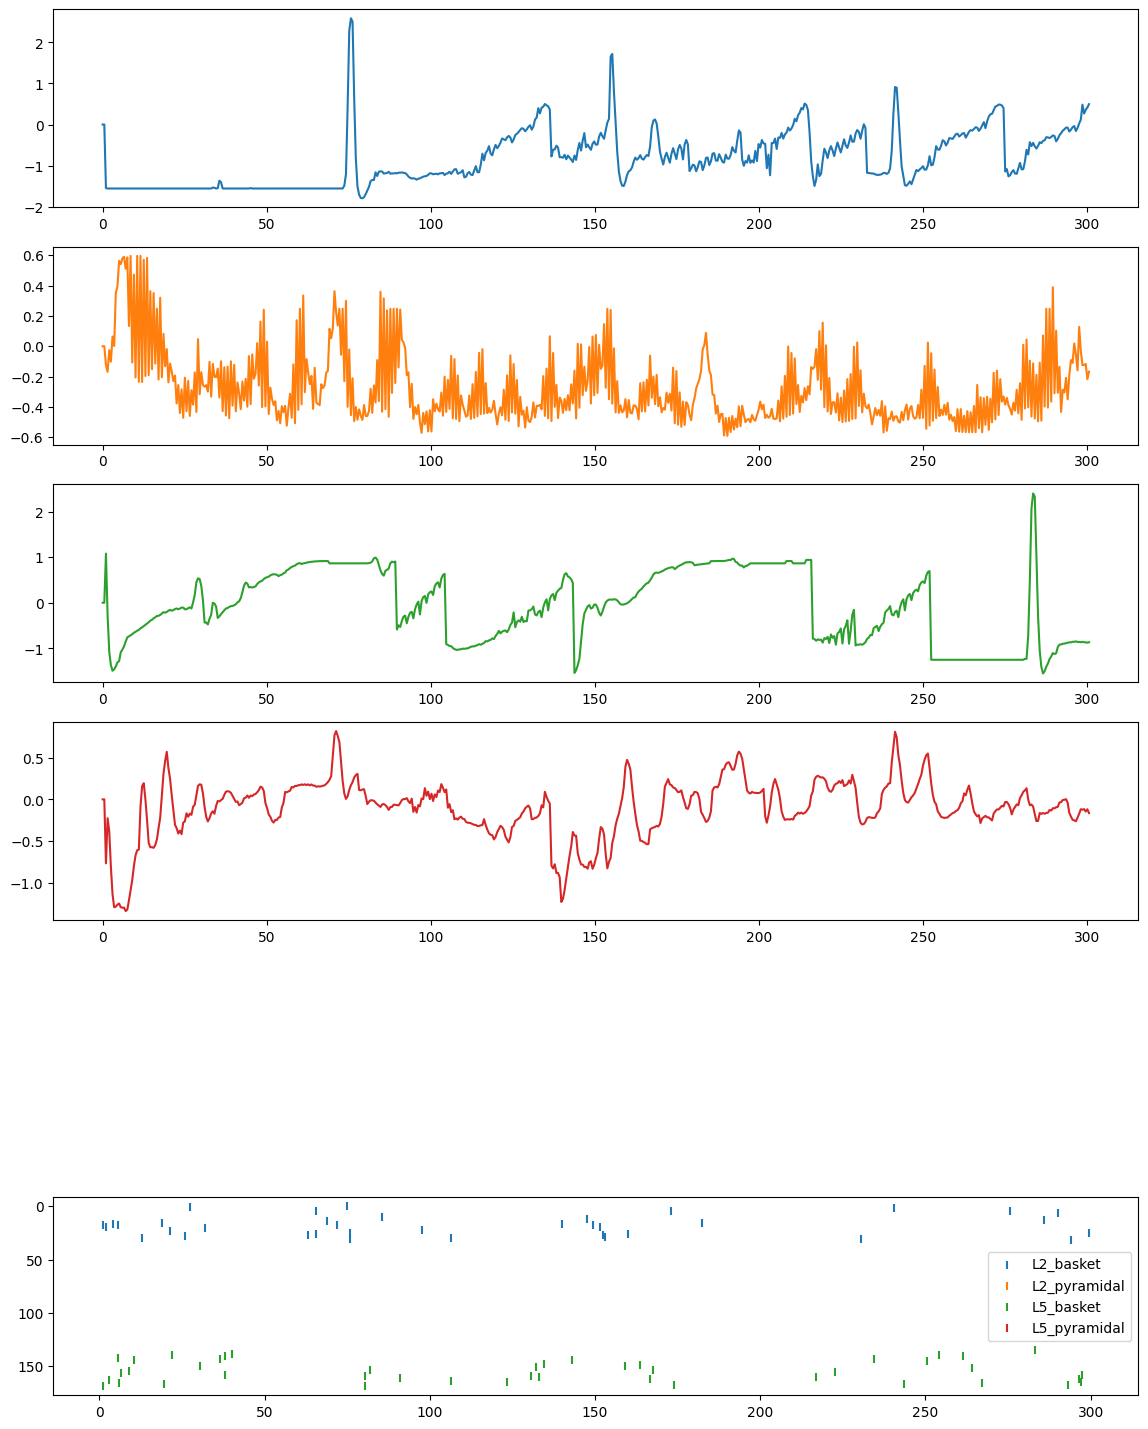

In [12]:
plt.figure(figsize=(14, 18))
for idx, cell_type in enumerate(['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal']):
    out = pred_y[idx][:,:,0].detach().cpu().numpy()

    plt.subplot(6, 1, idx+1)
    pred_trace = out[:,0]
    plt.plot(np.linspace(0, pred_trace.size * 0.5, pred_trace.size), pred_trace, c=f'C{idx}', label=cell_type)

    threshold = model.threshold_dict[cell_type].detach().cpu().numpy()

    cell_spikes = (out > threshold) & (np.roll(out, 1, axis=0) < threshold)
    cell_spike_indices = np.where(cell_spikes > 0)
    offset =  list(net.gid_ranges[cell_type])[0]

    plt.subplot(6, 1, 6)
    plt.scatter(cell_spike_indices[0] * 0.5, cell_spike_indices[1] + offset, c=f'C{idx}', marker='|', label=cell_type)

# plt.subplot(6,1,5)
# dpl_trace = dpl.detach().cpu().numpy()
# plt.plot(np.linspace(0, dpl_trace.size * 0.5, dpl_trace.size), dpl_trace, c='k', label='dpl')

plt.subplot(6,1,6)
plt.gca().invert_yaxis()
plt.legend()
    

In [47]:
# print_freq = 1

# max_epochs = 100

# EI_dict_list = [np.array([val.clone().cpu().item() for val in model.EI_dict.values()])]
# losses = list()
# for epoch in range(max_epochs):
#     model.train()
#     optimizer.zero_grad()
#     # input_spikes = input_spike_dict.clone().to(device).requires_grad_(False)

#     pred_y = model(input_spike_dict['L5_pyramidal'].clone(), input_spike_dict['L2_pyramidal'].clone(),
#                     input_spike_dict['L5_basket'].clone(), input_spike_dict['L2_basket'].clone())


#     # dpl = pred_y[1][:,:,-1].mean(axis=1) + pred_y[3][:,:,-1].mean(axis=1)
#     # dpl = pred_y[1][:,:,-1].mean(axis=1)
#     dpl = pred_y[3][:,:,-1].mean(axis=1)

#     out_fft = torch.fft.rfft(dpl).abs() ** 2
#     freq = torch.fft.rfftfreq(pred_y[1].size(0), dt / 1e3)


#     power = torch.sum(out_fft[torch.logical_and(freq > 15, freq < 60)])
#     # denom = torch.sum(out_fft[torch.logical_and(freq < 30, freq > 0)]) + torch.sum(out_fft[torch.logical_and(freq < 100, freq > 40)])

#     relative_power = - torch.log(power) 
#     # relative_power = - power 

#     relative_power.backward()
#     optimizer.step()

#     losses.append(relative_power.item())

#     #Print Loss Scores
#     if (epoch+1)%print_freq == 0:
#         print('')
#         print('Epoch: {}/{} ...'.format(epoch+1, max_epochs), end=' ')
#         print('Relative Power: {:.4f}'.format(-relative_power))

#     else:
#         print('*', end='')

#     EI_vals = np.array([val.clone().cpu().item() for val in model.EI_dict.values()])
#     EI_dict_list.append(EI_vals)


In [48]:
# EI_array = np.array(EI_dict_list)
# df = pd.DataFrame(EI_array, columns=model.EI_dict.keys())
# # _ = plt.plot(EI_array)
# sns.heatmap(df.T, cmap='RdBu_r', center=0, vmin=-3, vmax=3)
# plt.xlabel('Epoch')

NameError: name 'EI_dict_list' is not defined

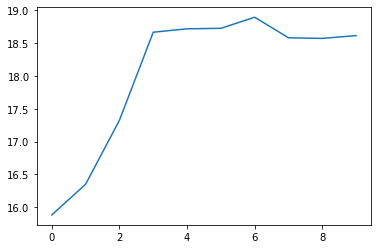

In [11]:
plt.plot(-np.array(losses))
# plt.xlim(0,30)

Text(0, 0.5, 'Power')

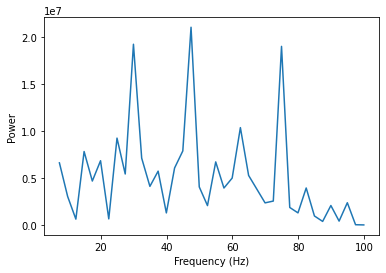

In [12]:
mask = np.logical_and(freq > 5, freq < 100).numpy().astype(bool)
plt.plot(freq.detach().cpu().numpy()[mask], out_fft.detach().cpu().numpy()[mask])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

In [13]:
model.delay_matrix.shape

(384, 134)

In [14]:
# Make input spike dict initialized with prox/distal noisy drive
input_spike_dict = dict()
for cell_type in net.cell_types:
    gid_list = net.gid_ranges[cell_type]
    input_spike_dict[cell_type] = torch.from_numpy(
        np.stack([network_data_drive.input_spike_dict[gid].T for gid in gid_list])).float()[:, :, :].to(device)

plot_epoch = 0
for key in df.columns:
    model.EI_dict[key] = torch.tensor(df[key].values[plot_epoch]).to(device)

with torch.no_grad():
    model.train()
    # model.eval()
    pred_y = model(input_spike_dict['L5_pyramidal'].clone(), input_spike_dict['L2_pyramidal'].clone(),
                    input_spike_dict['L5_basket'].clone(), input_spike_dict['L2_basket'].clone())

dpl = pred_y[1][:,:,1].mean(axis=1) + pred_y[3][:,:,1].mean(axis=1)
dpl_l2 = pred_y[1][:,:,1].mean(axis=1)
dpl_l5 = pred_y[3][:,:,1].mean(axis=1)

out_fft = torch.fft.rfft(dpl).abs() ** 2
out_fft_l2 = torch.fft.rfft(dpl_l2).abs() ** 2
out_fft_l5 = torch.fft.rfft(dpl_l5).abs() ** 2

freq = torch.fft.rfftfreq(pred_y[1].size(0), dt / 1e3)

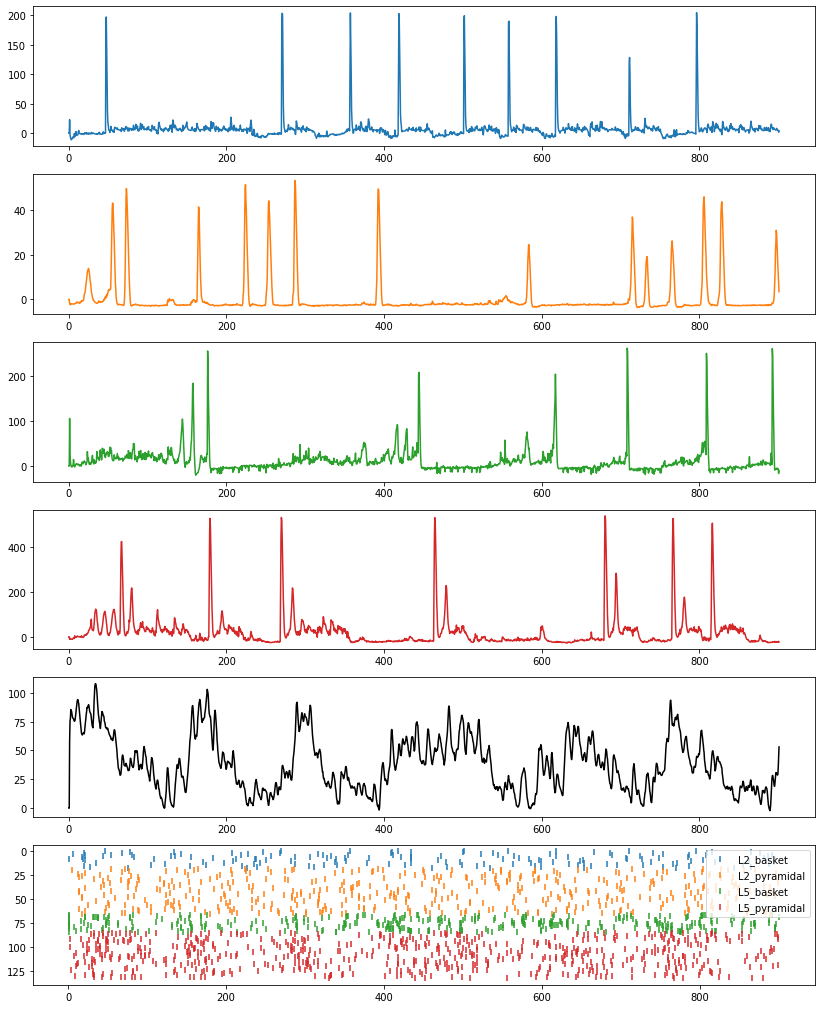

In [15]:
plt.figure(figsize=(14, 18))
for idx, cell_type in enumerate(['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal']):
    out = pred_y[idx][:,:,0].detach().cpu().numpy()

    plt.subplot(6, 1, idx+1)
    pred_trace = out[:,0]
    plt.plot(np.linspace(0, pred_trace.size * 0.5, pred_trace.size), pred_trace, c=f'C{idx}', label=cell_type)

    threshold = model.threshold_dict[cell_type].detach().cpu().numpy()

    cell_spikes = (out > threshold) & (np.roll(out, 1, axis=0) < threshold)
    cell_spike_indices = np.where(cell_spikes > 0)
    offset =  list(net.gid_ranges[cell_type])[0]

    plt.subplot(6, 1, 6)
    plt.scatter(cell_spike_indices[0] * 0.5, cell_spike_indices[1] + offset, c=f'C{idx}', marker='|', label=cell_type)

plt.subplot(6,1,5)
dpl_trace = dpl.detach().cpu().numpy()
plt.plot(np.linspace(0, dpl_trace.size * 0.5, dpl_trace.size), dpl_trace, c='k', label='dpl')

plt.subplot(6,1,6)
plt.gca().invert_yaxis()
plt.legend()
    

Text(0, 0.5, 'Power')

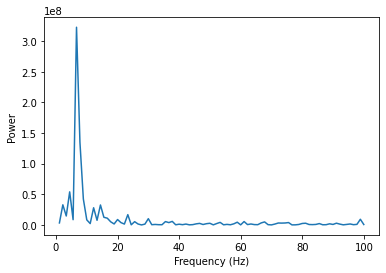

In [16]:
mask = np.logical_and(freq > 0, freq < 100).numpy().astype(bool)
# plt.plot(freq.detach().cpu().numpy()[mask], out_fft_l2.detach().cpu().numpy()[mask])
plt.plot(freq.detach().cpu().numpy()[mask], out_fft_l5.detach().cpu().numpy()[mask])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
# plt.xlim(0,40)


In [17]:
# optim_res = {
#     'losses': losses,
#     'EI_array': EI_array,
#     'EI_dict_keys': list(model.EI_dict.keys()),
#     'prior_dict': prior_dict,
#     'theta_dict': theta_dict, # Initial values of parameters
#     'dt': dt,
#     'net_drive': net_drive,
#     'net_connectivity': net_connectivity,
# }

In [18]:
# with open(f'surrogate_plot_data/lowfreq_optim_res_low_to_beta.pkl', 'wb') as f:
#     dill.dump(optim_res, f)